# Quantum pipeline using the Quantum Trainer

In [13]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [14]:
import numpy as np

BATCH_SIZE = 30
EPOCHS = 120
SEED = 2
len_dataset = 100

### Read in the data and create diagrams

In [15]:
import pandas as pd

train_split = int(len_dataset * 0.8)
val_split = int(len_dataset * 0.9)
test_split = int(len_dataset)

df = pd.read_csv('./datasets/sentiment_with_connector' + '.csv')
df.head()
df_negative = df[df['labels'] == 0]
df_positive = df[df['labels'] == 1]
df_negative = df_negative.sample(frac=1).reset_index(drop=True)
df_positive = df_positive.sample(frac=1).reset_index(drop=True)

df_positive = df_positive[:int(len_dataset/2)]
df_negative = df_negative[:int(len_dataset/2)]

df_final = pd.concat([df_positive, df_negative])

data = list(df_final['sentences'])
labels_raw = list(df_final['labels'])

labels = [[x, 1-x] for x in labels_raw]

train_data = data[:train_split]
dev_data = data[train_split:val_split]
test_data = data[val_split:test_split]

train_labels = labels[:train_split]
dev_labels = labels[train_split:val_split]
test_labels = labels[val_split:test_split]

### Create diagrams

In [16]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
raw_test_diagrams = parser.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Remove the cups

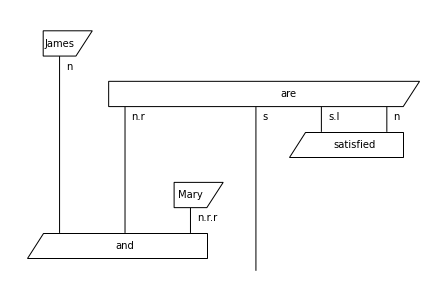

In [17]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

### Create circuits

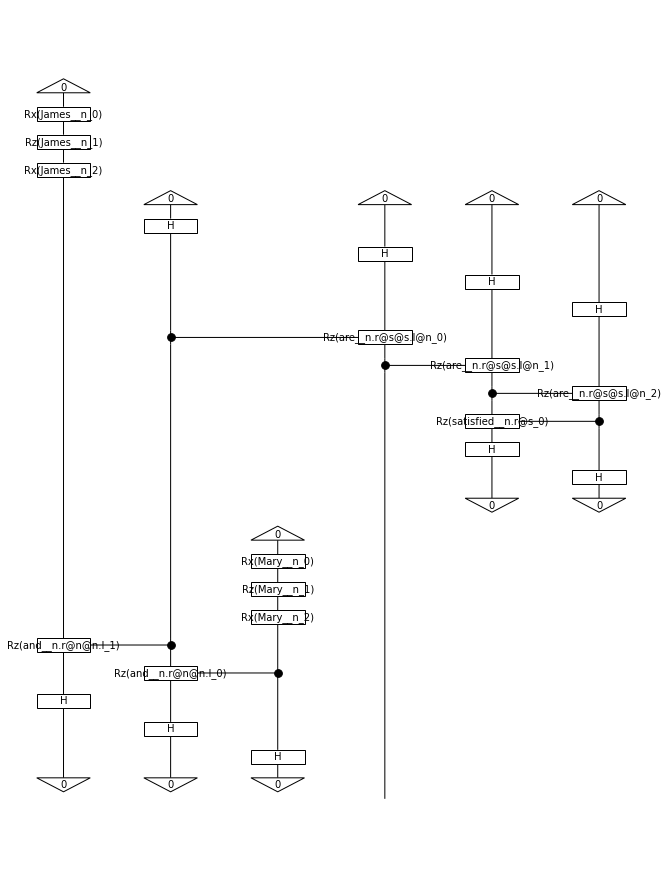

In [18]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

### Parameterise

In [19]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits+dev_circuits+test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

### Define evaluation metric

In [20]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

### Initialize trainer

In [21]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [22]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

### Train

In [23]:
trainer.fit(train_dataset, val_dataset, logging_step=12)

Epoch 1:     train/loss: 1.6399   valid/loss: 2.4521   train/acc: 0.6500   valid/acc: 0.2500
Epoch 100:   train/loss: 0.6837   valid/loss: 0.7352   train/acc: 0.5750   valid/acc: 0.4500
Epoch 200:   train/loss: 0.6766   valid/loss: 0.8647   train/acc: 0.6000   valid/acc: 0.2000
Epoch 300:   train/loss: 0.6386   valid/loss: 0.7334   train/acc: 0.6500   valid/acc: 0.4000
Epoch 400:   train/loss: 0.6214   valid/loss: 0.6801   train/acc: 0.7188   valid/acc: 0.6500
Epoch 500:   train/loss: 0.6565   valid/loss: 0.8157   train/acc: 0.7000   valid/acc: 0.2000
Epoch 600:   train/loss: 0.6011   valid/loss: 0.7976   train/acc: 0.7500   valid/acc: 0.3000
Epoch 700:   train/loss: 0.6091   valid/loss: 0.8748   train/acc: 0.7312   valid/acc: 0.0000
Epoch 800:   train/loss: 0.6238   valid/loss: 0.8287   train/acc: 0.6750   valid/acc: 0.1500
Epoch 900:   train/loss: 0.6074   valid/loss: 0.9426   train/acc: 0.6875   valid/acc: 0.3000
Epoch 1000:  train/loss: 0.6105   valid/loss: 0.8779   train/acc: 0.68

### Show results

Test accuracy: 0.3


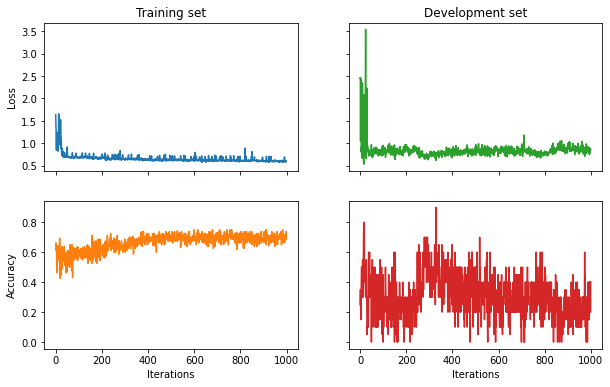

In [24]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)